# 1. Import Dependencies and Data

In [2]:
!pip list

Package                      Version
---------------------------- -----------
absl-py                      1.4.0
anyio                        4.2.0
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
array-record                 0.4.0
asttokens                    2.0.5
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        23.1.0
Babel                        2.11.0
backcall                     0.2.0
beautifulsoup4               4.12.3
bleach                       4.1.0
Brotli                       1.0.9
cachetools                   5.4.0
certifi                      2024.7.4
cffi                         1.16.0
charset-normalizer           3.3.2
click                        8.1.7
colorama                     0.4.6
comm                         0.2.1
contourpy                    1.1.1
cycler                       0.12.1
debugpy                      1.6.7
decorator                    5.1.1
defusedxml                   0.7.1
dm

In [2]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)

# Disable GPU entirely by setting the logical device configuration to empty
if gpus:
    try:
        # Disabling all visible GPUs
        tf.config.set_visible_devices([], 'GPU')
        print("GPU disabled.")
    except RuntimeError as e:
        # Disabling GPU after runtime initialization is not allowed
        print(f"Error disabling GPU: {e}")

# Perform operations on the CPU
with tf.device('/CPU:0'):
    a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
    b = tf.constant([[1.0, 1.0], [1.0, 1.0]])
    c = tf.matmul(a, b)
    print("Result of matrix multiplication on CPU:", c)


Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU disabled.
Result of matrix multiplication on CPU: tf.Tensor(
[[3. 3.]
 [7. 7.]], shape=(2, 2), dtype=float32)


In [3]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [4]:
ds = tfds.load('fashion_mnist', split='train')

In [5]:
ds.as_numpy_iterator().next()['label']

2

# 2. Viz Data and Build Dataset

In [6]:
# Do some data transformation
import numpy as np

In [7]:
# Setup connection aka iterator
dataiterator = ds.as_numpy_iterator()

In [8]:
# Getting data out of the pipeline
dataiterator.next()['image']

array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 18],
        [ 77],
        [227],
        [227],
        [208],
        [210],
        [225],
        [216],
        [ 85],
        [ 32],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 61],
        [100],
        [ 97],
        [ 80],
        [ 57],
        [117],
        [227],
        [238],
        [115],
        [ 49],
        [ 78],
        [106],
        [108],
        [ 71],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 81],
        [105],
        [ 80],
        [ 69],
      

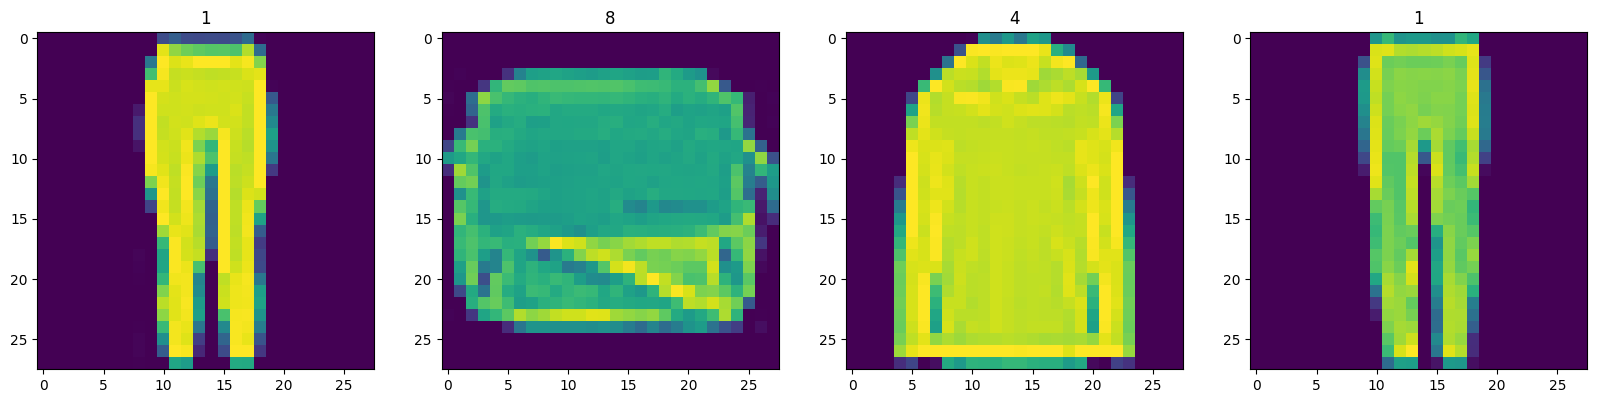

In [9]:
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx in range(4): 
    # Grab an image and label
    sample = dataiterator.next()
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(sample['image']))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(sample['label'])

In [10]:
# Scale and return images only 
def scale_images(data): 
    image = data['image']
    return image / 255

In [11]:
# Reload the dataset 
ds = tfds.load('fashion_mnist', split='train')
# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# Cache the dataset for that batch 
ds = ds.cache()
# Shuffle it up 
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(64, drop_remainder=True)
# Reduces the likelihood of bottlenecking 
ds = ds.prefetch(64)

In [12]:
ds.as_numpy_iterator().next().shape

(64, 28, 28, 1)

# 3. Build Neural Network

### 3.1 Import Modelling Components

In [13]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D
batch_size = 16  # Adjust based on available RAM

### 3.2 Build Generator

In [31]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Reshape, UpSampling2D, Conv2D

# Define the model
def build_generator():
    model = Sequential()
    
    # Takes in random values and reshapes it to 7x7x128
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    
    # Upsampling block 1 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model

In [32]:
generator = build_generator()

In [33]:
generator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_4 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_8 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_20 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

In [34]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3266717715434655744
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5714739200
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8646281625016641126
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [35]:
import tensorflow_datasets as tfds

# Load a dataset
dataset = tfds.load('fashion_mnist', split='train')
print("Dataset loaded successfully.")


Dataset loaded successfully.


In [36]:
generator = build_generator()

In [37]:
import tensorflow as tf

# Configure GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


Physical devices cannot be modified after being initialized


In [38]:
test_input = np.random.randn(1, 128)
print(test_input)
img = generator.predict(test_input)
# print(img.shape)  # Should print (4, 28, 28, 1)


[[ 0.36155396 -2.87370504  0.42071984 -0.35516638  0.33078402  1.36917673
   0.54099345  0.30495684 -0.02194486  1.79732979  0.39569293  0.69805276
  -2.03963677 -0.74646113 -0.50354079  1.86013898 -0.0707209   0.36849161
  -0.23634113  0.87531624  0.56981413  0.24187005  1.49275754 -0.09586368
  -0.09791198  0.78246727  0.8883327  -0.25342962  1.40457854  0.14078086
  -0.93440114 -0.23833455 -0.09888894  1.31533384 -1.87697965 -1.78919077
   1.19793001 -2.02917449 -0.31874135  0.06811272  0.18878358 -0.94048444
   0.3872151   0.47297955 -0.69361362 -0.13095252  0.03914142 -1.13354722
  -0.29187643 -0.73363069 -0.32972966 -0.82122889 -1.17121111 -0.86629399
  -0.06288761  0.43833023  0.02746688  0.10917958  0.43380483  1.22643824
  -0.00402062  0.03881581 -0.65331553 -0.49455091 -1.12744625 -0.69913038
   0.56106978 -1.31439798 -1.3548455   1.32622026 -0.58314519 -1.74735976
  -1.37953825  1.09523488  1.04409482 -0.3373475   0.51895389  0.84012698
  -0.62482019 -1.63773908 -0.74821831 

1/1 [==============================] - 0s 51ms/step
(4, 28, 28, 1)


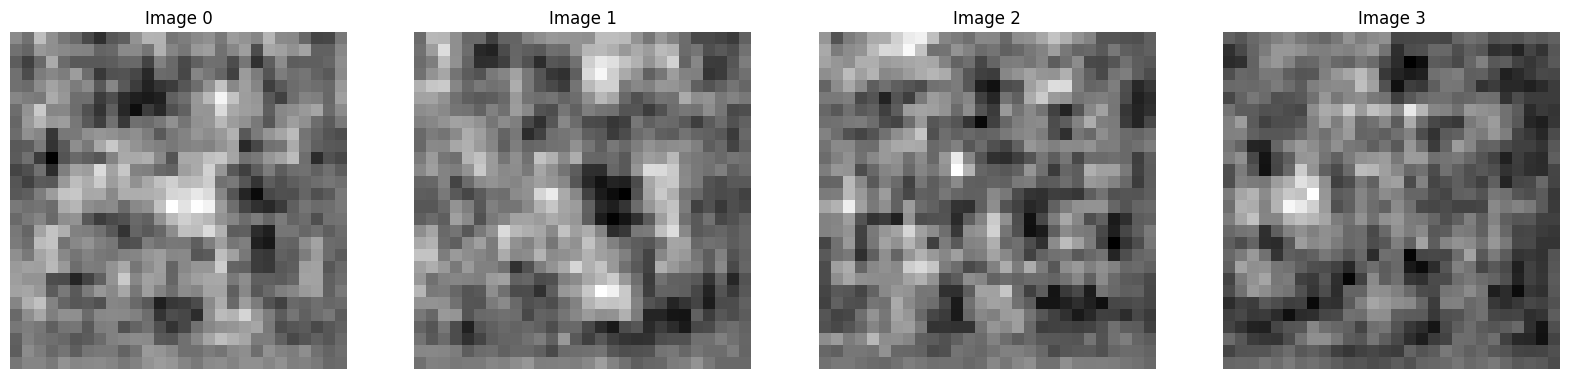

In [39]:
# Generate new fashion
noise = np.random.randn(4, 128)
generated_images = generator.predict(noise)
print(generated_images.shape)
# Display generated images
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(generated_images):  # Use `generated_images` directly
    ax[idx].imshow(np.squeeze(img), cmap='gray')  # Remove singleton dimensions
    ax[idx].axis('off')  # Hide axes
    ax[idx].title.set_text(f'Image {idx}')
plt.show()


### 3.3 Build Discriminator

In [40]:
def build_discriminator(): 
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model 

In [41]:
discriminator = build_discriminator()

In [42]:
discriminator.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_31 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_31 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_32 (Conv2D)          (None, 16, 16, 128)      

In [43]:
img = img[0]

In [44]:
img.shape

(28, 1)

# 4. Construct Training Loop

### 4.1 Setup Losses and Optimizers

In [45]:
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss for both 
from tensorflow.keras.losses import BinaryCrossentropy

In [46]:
g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.00001) 
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

### 4.2 Build Subclassed Model

In [47]:
# Importing the base model class to subclass our training step 
from tensorflow.keras.models import Model

In [48]:
class FashionGAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        # Get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [49]:
# Create instance of subclassed model
fashgan = FashionGAN(generator, discriminator)

In [50]:
# Compile the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

### 4.3 Build Callback

In [51]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [52]:
import os
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.image import array_to_img

class ModelMonitor(Callback):
    def __init__(self, num_img=4):
        self.num_img = num_img
        self.save_dir = os.path.join(os.getcwd(), 'images')

        # Ensure that the 'images' directory exists
        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)

    def on_epoch_end(self, epoch, logs=None):
        # Pass the correct input shape to the generator
        noise = tf.random.normal((self.num_img, 128))  # Shape should match the generator's expected input
        generated_images = self.model.generator(noise, training=False)

        # Resize the images if needed
        generated_images = tf.image.resize(generated_images, [28, 28])

        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join(self.save_dir, f'generated_img_{epoch}_{i}.png'))

In [53]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


### 4.3 Train 

In [54]:
# Recommend 2000 epochs
hist = fashgan.fit(ds, epochs=10, callbacks=[ModelMonitor()])

Epoch 1/10
937/937 [==============================] - 7088s 8s/step - d_loss: 0.6128 - g_loss: 0.9358
Epoch 2/10
937/937 [==============================] - 6536s 7s/step - d_loss: 0.6425 - g_loss: 0.8503
Epoch 3/10
937/937 [==============================] - 6297s 7s/step - d_loss: 0.6631 - g_loss: 0.7953
Epoch 4/10
937/937 [==============================] - 6229s 7s/step - d_loss: 0.6532 - g_loss: 0.8321
Epoch 5/10
937/937 [==============================] - 5832s 6s/step - d_loss: 0.6115 - g_loss: 1.0701
Epoch 6/10
937/937 [==============================] - 5570s 6s/step - d_loss: 0.2752 - g_loss: 2.6088
Epoch 7/10
937/937 [==============================] - 5520s 6s/step - d_loss: 0.2691 - g_loss: 2.6809
Epoch 8/10
937/937 [==============================] - 5560s 6s/step - d_loss: 0.2677 - g_loss: 2.7185
Epoch 9/10
937/937 [==============================] - 5613s 6s/step - d_loss: 0.3204 - g_loss: 2.4802
Epoch 10/10
937/937 [==============================] - 5564s 6s/step - d_loss: 0.3

### 4.4 Review Performance

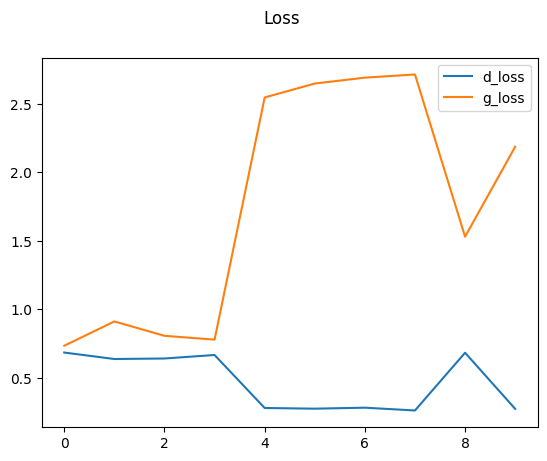

In [55]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

# 5. Test Out the Generator

### 5.1 Generate Images

In [56]:
import os
from tensorflow.keras.models import load_model

# Check the current working directory
print("Current working directory:", os.getcwd())

# Check if the file exists
file_path = os.path.join('archive', 'generatormodel.h5')
if os.path.exists(file_path):
    print("File found:", file_path)
    generator.load_weights(file_path)
else:
    print("File not found:", file_path)


Current working directory: C:\Users\Lenovo\Downloads\GANBasics-main\GANBasics-main
File not found: archive\generatormodel.h5


In [57]:
generator.save_weights('generatormodelll.h5')

In [58]:
# Assuming latent_dim is 128
latent_dim = 128
random_input = tf.random.normal((16, latent_dim))
imgs = generator.predict(random_input)


1/1 [==============================] - 0s 173ms/step


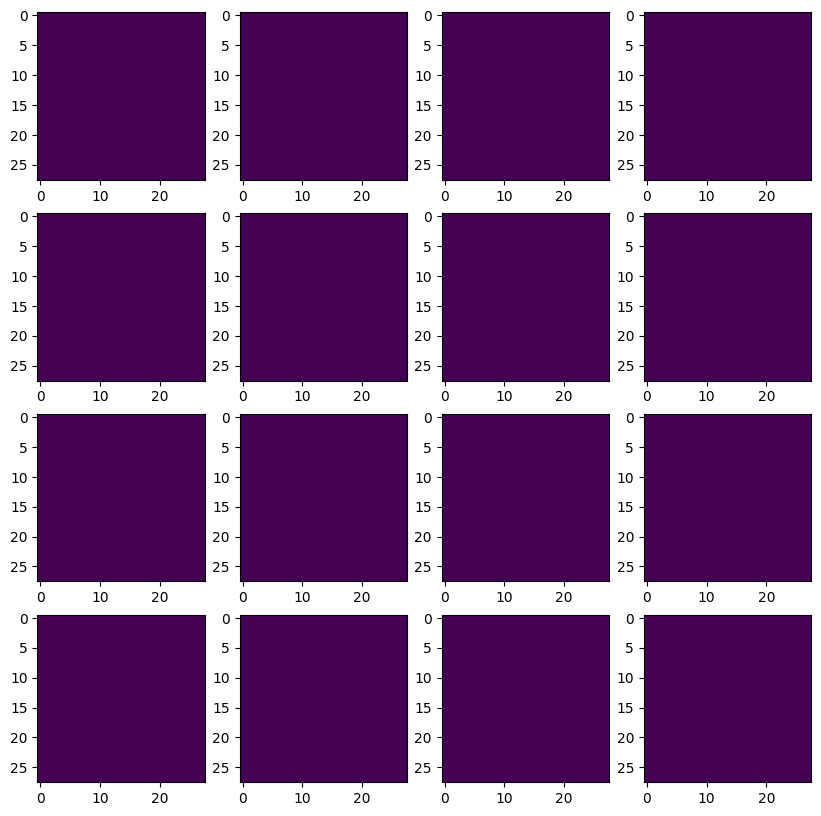

In [59]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

### 5.2 Save the Model

In [60]:
generator.save('generatorr.h5')
discriminator.save('discriminatorr.h5')